# RNNLunchJ Better Version

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-Processing

### Download data

In [ ]:
! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
! mv MLchallenge2_training.csv train_data.csv

! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
! mv MLchallenge2_testing_inputs.csv test_data.csv

--2020-12-17 18:47:15--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285951722 (273M) [text/csv]
Saving to: ‘MLchallenge2_training.csv’

MLchallenge2_traini 100%[===================>] 272.70M  85.4MB/s    in 3.4s    

2020-12-17 18:47:19 (80.1 MB/s) - ‘MLchallenge2_training.csv’ saved [285951722/285951722]

--2020-12-17 18:47:19--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173137112 (165M) [text/csv]
Saving to: ‘MLchallenge2_testing_inputs.csv’

MLchallenge2_testin 100%[===================>] 165.12M  78.9MB/s    in

### Do Basic Imports

In [ ]:
import numpy as np
from tensorflow import keras
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

### Read training data

Read training data from .csv file and convert to a numpy array

In [ ]:
csv_train = pandas.read_csv("train_data.csv")
unparsed_train = np.array(csv_train)

In [ ]:
# test_csv = pandas.read_csv("newTestData.csv")
csv_test = pandas.read_csv("drive/MyDrive/tracking_testData.csv")
unparsed_test = np.array(csv_test)

### Read testing data

A bit harder than the previous since data is incomplete pandas can't read it easily, plus the headers are missing aswell...

### Read new testing data

### Parse Data


In [ ]:
def parser(data, use7inputs=True):
  nStep = 6
  nInputs = 6
  nOutputs = 6
  inputLayers = 24

  x = []
  y = []

  for i in range(len(data)):
    index = 0 
    one_set_x = []
    one_set_y = []
    while index < data.shape[1]-6:
      mid = index+nInputs
      # tmp = np.append(data[i][index:mid],data[i][mid+2] - data[i][index+2])

      if use7inputs:
        tmp = np.append(data[i][index:mid],data[i][mid+2])
        one_set_x.append(tmp)
        
        # tmp = np.append(data[i][index:mid],data[i][mid+2] - data[i][index+2])
        # one_set_x.append(tmp)
      else:
        one_set_x.append(data[i][index:mid])
      
      # TimeSeries needs a 3D output too; so when using Time you need .append
      # one_set_y.append(data[i][mid:mid+nOutputs])
      tmp = np.append(data[i][mid:mid+2],data[i][mid+3:mid+nOutputs])
      one_set_y.append(tmp)
      if len(one_set_x) == inputLayers:
        x.append(one_set_x)
        y.append(one_set_y)
        one_set_x = one_set_x[1:]
        # if using Time uncomment
        one_set_y = one_set_y[1:]
      index += nStep

  x = np.array(x)
  y = np.array(y)
  print("shape of x: ", x.shape)
  print("shape of y: ", y.shape)
  return x, y

In [ ]:
def reverse_parser(data, use7inputs=True):
  nStep = 6
  nInputs = 6
  nOutputs = 6
  inputLayers = 24

  x = []
  y = []

  for i in range(len(data)):
    index = data.shape[1]
    one_set_x = []
    one_set_y = []
    while index > 6:
      mid = index-nInputs
      # tmp = np.append(data[i][index:mid],data[i][mid+2] - data[i][index+2])

      if use7inputs:
        tmp = np.append(data[i][mid:index],data[i][mid-4])
        one_set_x.append(tmp)

        # tmp = np.append(data[i][mid:index],data[i][mid-4]-data[i][index-4])
        # one_set_x.append(tmp)
      else:
        one_set_x.append(data[i][mid:index])
      
      # TimeSeries needs a 3D output too; so when using Time you need .append

      # one_set_y.append(data[i][mid-nOutputs:mid])
      tmp = np.append(data[i][mid-nOutputs:mid-4],data[i][mid-3:mid])
      one_set_y.append(tmp)
      if len(one_set_x) == inputLayers:
        x.append(one_set_x)
        y.append(one_set_y)
        one_set_x = one_set_x[1:]
        # if using Time uncomment
        one_set_y = one_set_y[1:]
      index -= nStep

  x = np.array(x)
  y = np.array(y)
  print("shape of x: ", x.shape)
  print("shape of y: ", y.shape)
  return x, y
np.set_printoptions(suppress=True)

# tx_, ty_ = parser(unparsed_train[:10])
# tx_r, ty_r = reverse_parser(unparsed_train[:10])
# print(np.around(tx_[0,:,0],3))
# print(np.around(tx_r[0,:,0],3))

In [ ]:
def NaiveParser(data):
  nStep = 6
  nInputs = 6
  nOutputs = 6
  inputLayers = 23

  x = []
  
  for i in range(len(data)):
    index = 0
    one_set_x = []
    while index < 144:
      one_set_x.append(data[i][index:index+nInputs]) # + data[i,mid+3] # later fix to get z value
      index += nStep
    x.append(one_set_x)


  x = np.array(x)
  print("shape of x: ", x.shape)
  return x

In [ ]:
x_train, y_train = parser(unparsed_train[:170000])

shape of x:  (170000, 24, 7)
shape of y:  (170000, 24, 5)


In [ ]:
x_val, y_val = parser(unparsed_train[170000:180000])

shape of x:  (10000, 24, 7)
shape of y:  (10000, 24, 5)


In [ ]:
x_newtest, y_newtest = parser(unparsed_train[180000:])

shape of x:  (14601, 24, 7)
shape of y:  (14601, 24, 5)


In [ ]:
x_test, y_test = parser(unparsed_test)

shape of x:  (14601, 24, 7)
shape of y:  (14601, 24, 5)


In [ ]:
test_labels = NaiveParser(unparsed_train[180000:])

shape of x:  (14601, 24, 6)


In [ ]:
def minMaxNormalization(x_train, x_val, x_test):
    mx = x_train.max()
    mn = x_train.min()
    x_train = (x_train - mn) / (mx - mn)
    x_val = (x_val - mn) / (mx - mn)
    x_test = (x_test - mn) / (mx - mn)
    return x_train, x_val, x_test, mn, mx

In [ ]:
x_train, x_val, x_test, minimum, maximum = minMaxNormalization(x_train, x_val, x_test)
x_newtest = (x_newtest - minimum) / (maximum - minimum)

## Model

### Different models

RNNTime
- Returns with TimeSteps
- As I understand it so far:
  - Feeds first data given, predicts next
  - Feeds next data while remembering the previous data point and predicting the next relative to the one just fed.
  - Here, just look at [this](https://i.stack.imgur.com/13opm.jpg) image and [this](https://github.com/MohammadFneish7/Keras_LSTM_Diagram) diagram
- In the end returns a shape (timesteps,6)

RNNTimeStateful
- Stateful only resets the RNN memory when manually reset...
- Not the best with the current .fit() code

In [ ]:
def RNNTime(x):
    x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=False, return_sequences=True)(x) #, batch_input_shape=(128,None,6)
    x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
    x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'))(x)
    return x

def RNNTimeStateful(x):
    # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
    x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', stateful=True, return_sequences=True)(x)
    x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=True, return_sequences=True)(x)
    x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=True, return_sequences=True)(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
    x = keras.layers.TimeDistributed(keras.layers.Dense(5, activation='linear'))(x)
    return x

### Build model

Set a constant seed to test if model is just bad or bad random values

In [ ]:
inputs = keras.layers.Input((None,7))
print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end

x = RNNTime(inputs)
# x = RNNTimeStateful(inputs)
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

train shape of one batch: (24, 7)


### Compile Model

In [ ]:
# --==Not in use?==--
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.8)

optimizer = keras.optimizers.Adam(learning_rate=0.001)


#--==Set Weights==--
# loss_weights = [1/(0.20374708177972334**2),
#                 1/(0.2713061404371925**2),
#                 1/(0.10484799308587896**2),
#                 1/(0.10405550103569539**2),
#                 1/(0.10972255464315309**2),
#                 1/(0.8609325026290453**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])


model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

model.summary()

Model: "RNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 7)]         0         
_________________________________________________________________
input_lstm1 (LSTM)           (None, None, 128)         69632     
_________________________________________________________________
lstm2 (LSTM)                 (None, None, 64)          49408     
_________________________________________________________________
lstm3 (LSTM)                 (None, None, 32)          12416     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          1056      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 5)           165       
Total params: 132,677
Trainable params: 132,677
Non-trainable params: 0
____________________________________________________

## Fit model

Gets stuck on loss=105 for ~10 epochs for some reason...


In [ ]:
# Current Best
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='min', verbose=1, restore_best_weights=True)
H = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, shuffle=True, verbose=1, callbacks=[es], validation_data=(x_val, y_val))

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])


### Save Model

In [ ]:
model.save('RNNModel.h5', save_format="h5")

## Load Model

In [ ]:
# model = keras.models.load_model('RNNModel.h5')
model = keras.models.load_model('drive/MyDrive/7in-5out-abs.h5')
# model = keras.models.load_model('drive/MyDrive/RNNModel.h5')

## Test the model

### Making a new model
Making a new model with batch_size=1

Then loading old weights into the newly created model.

In [ ]:
inputs = keras.layers.Input((None,7), batch_size=1)
x = RNNTimeStateful(inputs)
old_weights = model.get_weights()
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
model.set_weights(old_weights)

### Testing new model

In [ ]:
# 1.You can run the testing script in the attached notebook on the test data (with knocked out layers) that I sent earlier and report the performance with the help of plots.
# 2.You can use dataset[180000:] i.e. all the samples after index 180K from the original dataset file itself. I suppose these examples do not overlap with training or validation set.
#   ✅ a.Assume all the layers after layer 15 are missing and predict them using the current strategy.
#   ✅ b.Assume all the layers after layer 7 are missing….
#   ✅ c.Assume all the layers after layer 3 are missing…
#   ✅ d.Assume layers 4 through 12 are missing…
#   ✅ e.Assume layers 8 through 12 are missing…
# (** Above I assumed the indexing of layers start with 1.)
# 3.You can report performance on these different use cases using plots or normal distribution.
# 4.I’m curious if the model gradually becomes less accurate for consecutive missing layers.

np.set_printoptions(suppress=True)

def missingTracks(test_data, test_labels, index_start, index_end=24, doPrint=True):
  print(test_data.shape)
  diff = []
  fpred = []
  true = []
  z_az = []
  for index in range(len(test_data)):
    t = test_data[index]
    # label = test_labels[index+1]


    # experimental code start
    flag = False
    # experimental code end

    goodValues = []
    t_diff = []
    t_pred = []
    t_true = []
    t_z_az = []
    for timestep_index in range(len(t)):
      timestep = t[timestep_index]
      # if isnan(timestep[0]):
      if timestep_index in range(index_start-1,index_end+1):
        # experimental code start
        if not flag:
          continue
        # experimental code end

        latestLayers = np.expand_dims(np.array(goodValues),0)
        pred = model.predict(latestLayers)[0][-1]

        z = t[timestep_index][2]
        z_next = t[timestep_index][6]

        new_labels = np.array(list(t[timestep_index,:2]) + list(t[timestep_index,3:6]))
        # new_labels = np.append(t[timestep_index,:2],t[timestep_index,3:6])
        new_labels = new_labels * (maximum - minimum) + minimum
        if doPrint:
          print("index",timestep_index)
          print(new_labels.shape)
          print(new_labels)
          print(test_labels[index][timestep_index])

        # t_diff.append(pred - test_labels[index][timestep_index])
        t_diff.append(pred - new_labels)
        t_pred.append(pred)
        # t_true.append(test_labels[index][timestep_index])
        # t_true.append(t[timestep_index])
        t_true.append(new_labels)
        t_z_az.append(np.array([z,z_next]) * (maximum - minimum) + minimum)

        if doPrint:
          # print(index, timestep_index, np.around(pred,3), np.around(test_labels[index][timestep_index], 3))
          print(index, timestep_index, np.around(pred,3), np.around(new_labels, 3))
          print("diff: ", np.around(t_diff[-1],3))
          print("==========================================")
        pred = (pred - minimum) / (maximum - minimum)

        if doPrint:
          print("z&nz",z,z_next)
          print("pred:2 ",pred[:2])
        next = np.append(pred[:2],z)
        next = np.append(next,pred[2:])
        next = np.append(next,z_next)
        if doPrint:
          print("nex.shp",next.shape)
          print("nx",next)
          print("tst",latestLayers[0][-1])
        goodValues = [next]
      else:
        # experimental code start
        flag = True
        # experimental code end
        goodValues.append(timestep)
    
    experiment = np.array(goodValues)
    experiment = np.expand_dims(experiment, 0)
    pred = model.predict(experiment)[0][-1]
    final = test_data.shape[1]-1

    z = t[timestep_index][2]
    z_next = t[timestep_index][6]

    new_labels = np.array(list(t[final,:2]) + list(t[final,3:6]))
    # new_labels = np.append(t[timestep_index,:2],t[timestep_index,3:6])
    new_labels = new_labels * (maximum - minimum) + minimum
    if doPrint:
      print(new_labels.shape)
      print(new_labels)
      print(test_labels[index][timestep_index])

    # t_diff.append(pred - test_labels[index][final])
    t_diff.append(pred - new_labels)
    t_pred.append(pred)
    # t_true.append(test_labels[index][timestep_index])
    t_true.append(new_labels)
    t_z_az.append(np.array([z,z_next]) * (maximum - minimum) + minimum)
    if doPrint:
      print(index, final, np.around(pred,3), np.around(new_labels, 3))
      print("diff: ", np.around(t_diff[-1],3))
      print("==========================================")

    if index%10 == 0:
      print("index:",index)
    
    model.reset_states()
    diff.append(t_diff)
    fpred.append(t_pred)
    true.append(t_true)
    z_az.append(t_z_az)
  diff = np.array(diff)
  pred = np.array(fpred)
  true = np.array(true)
  z_az = np.array(z_az)
  return diff, pred, true, z_az, index_start, index_end

### Generating and Graphing test predictions

#### Definitions

In [ ]:
# =============
# --==Graph==--
# =============

def graphRow(diff, pred, true, z_az, row, graph_index, ax, isLast=False):
    values = ['x','y','px','py','pz']
    limits = [[-40,40],[-40,40],[-0.2,0.2],[-0.2,0.2],[0.5,3.5]]

    (mu, sigma) = norm.fit(diff[:,row,graph_index])
    if isLast:
      print("layer" , str(x_newtest.shape[1]-1) ," |: mu: ", round(mu,3), "sigma: " , round(sigma,3))
    else:
      print("layer" , str(row+index_start) ," |: mu: ", round(mu,3), "sigma: " , round(sigma,3))
    _, bins, _ = ax[row,0].hist(diff[:,row,graph_index], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = ax[row,0].plot(bins, y, 'r--', linewidth=2)


    if isLast:
      ax[row,0].set_title("index: " + str(x_newtest.shape[1]-1))
    else:
      ax[row,0].set_title("index: " + str(row+index_start))
    ax[row,0].set_ylabel('ylabel')
    ax[row,0].set_xlabel('xlabel')


    ax[row,1].scatter(true[:,row,graph_index],pred[:,row,graph_index])
    ax[row,1].grid(True)

    if isLast:
      ax[row,1].set_title("index: " + str(x_newtest.shape[1]-1) + " pred vs true")
    else:
      ax[row,1].set_title("index: " + str(row+index_start) + " pred vs true")
    ax[row,1].set_ylabel("ylabel")
    ax[row,1].set_xlabel("xlabel")

    ax[row,1].set_xlim(limits[graph_index])
    ax[row,1].set_ylim(limits[graph_index])
    ax[row,1].plot(limits[graph_index],limits[graph_index], color='b')


def graph_missing_test(diff, pred, true, z_az, index_start, index_end, graph_index=0):
  height = (index_end - (index_start-1)) + 1
  width = 2

  fig, ax = plt.subplots(height,width,figsize=(width*5,height*5))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  for row in range(height-1):
    graphRow(diff,pred,true,z_az,row,graph_index,ax)
  graphRow(diff,pred,true,z_az,height-1,graph_index,ax,isLast=True)


  # (mu, sigma) = norm.fit(diff[:,height-1,graph_index])
  # print("layer" , str(x_newtest.shape[1]-1) ," |: mu: ", round(mu,3), "sigma: " , round(sigma,3))
  # _, bins, _ = ax[height-1,0].hist(diff[:,height-1,graph_index], 20, density=True)
  # y = norm.pdf(bins, mu, sigma)
  # l = ax[height-1,0].plot(bins, y, 'r--', linewidth=2)

  # ax[height-1,0].set_title("index: " + str(x_newtest.shape[1]-1))
  # ax[height-1,0].set_ylabel('ylabel')
  # ax[height-1,0].set_xlabel('xlabel')

  # ax[height-1,1].scatter(true[:,height-1,graph_index],pred[:,height-1,graph_index])
  # ax[height-1,1].grid(True)

  # ax[height-1,1].set_title("index: " + str(x_newtest.shape[1]-1) + " pred vs true")
  # ax[height-1,1].set_ylabel("ylabel")
  # ax[height-1,1].set_xlabel("xlabel")

  # ax[height-1,1].set_xlim(limits[graph_index])
  # ax[height-1,1].set_ylim(limits[graph_index])
  # ax[height-1,1].plot(limits[graph_index],limits[graph_index], color='b')

  fig.show()


#### Graphs

In [ ]:
diff,pred,true,z_az,index_start,index_end = missingTracks(x_newtest[0:150], y_newtest[0:150], index_start=11, index_end=15, doPrint=False)

(150, 24, 7)
index: 0
index: 10
index: 20
index: 30
index: 40
index: 50
index: 60
index: 70
index: 80
index: 90
index: 100
index: 110
index: 120
index: 130
index: 140


layer 11  |: mu:  0.094 sigma:  0.035
layer 12  |: mu:  0.091 sigma:  0.036
layer 13  |: mu:  0.083 sigma:  0.037
layer 14  |: mu:  0.098 sigma:  0.037
layer 15  |: mu:  0.095 sigma:  0.04
layer 23  |: mu:  0.094 sigma:  0.041


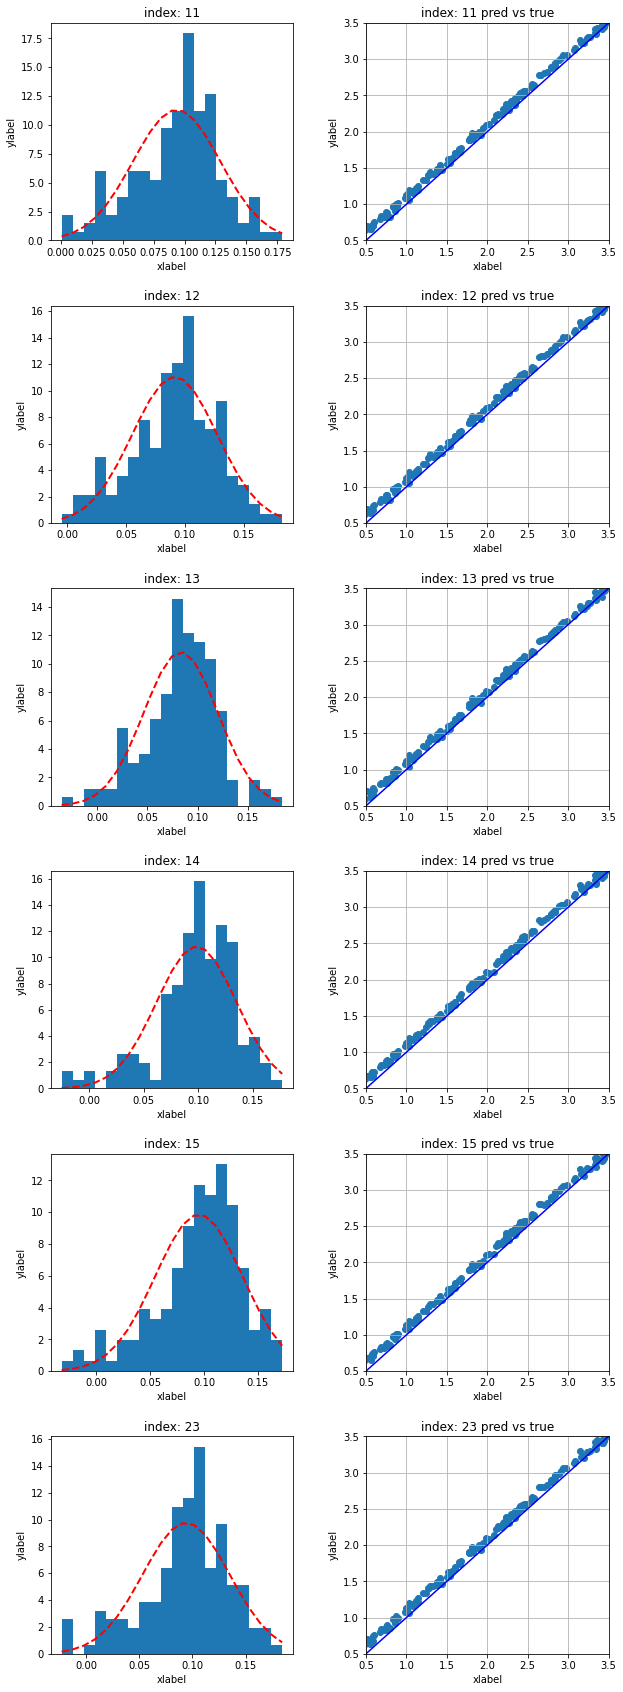

In [ ]:
graph_missing_test(diff, pred, true, z_az, index_start, index_end, 4)

### Development version

In [ ]:
#✅ a.Assume all the layers after layer 15 are missing and predict them using the current strategy.
#✅ b.Assume all the layers after layer 7 are missing….
#✅ c.Assume all the layers after layer 3 are missing…

# change index to desired value
index = 7

tmp = []
for set_ in range(len(x_newtest[:100])):
  time_tmp = []
  # time_tmp.append(x_test[set_,:15])
  for i in range(index):
    time_tmp.append(x_newtest[set_,i])
  for i in range(x_newtest.shape[1]-index):
    time_tmp.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
  tmp.append(time_tmp)
tmp = np.array(tmp)

diff = missingTracks(tmp, y_newtest, disable_print=True)

In [ ]:
# 3.You can report performance on these different use cases using plots or normal distribution.

height = x_newtest.shape[1] - index
width = 1

fig, ax = plt.subplots(height,width,figsize=(width*5,height*5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

if width > 1:
  for row in range(height):
    (mu, sigma) = norm.fit(diff[:,row,0])
    print("data" , str(row+index) ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = ax[row,0].hist(diff[:,row,0], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = ax[row,0].plot(bins, y, 'r--', linewidth=2)

    # ax[row,0].scatter(true_y[:,i],pred[:,i])
    # ax[row,0].grid(True)

    ax[row,0].set_title("index: " + str(row+index))
    ax[row,0].set_ylabel('ylabel')
    ax[row,0].set_xlabel('xlabel')
else:
  for row in range(height):
    (mu, sigma) = norm.fit(diff[:,row,0])
    print("data" , str(row+index) ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = ax[row].hist(diff[:,row,0], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = ax[row].plot(bins, y, 'r--', linewidth=2)

    # ax[row].scatter(true_y[:,i],pred[:,i])
    # ax[row].grid(True)

    ax[row].set_title("index: " + str(row+index))
    ax[row].set_ylabel('ylabel')
    ax[row].set_xlabel('xlabel')


fig.show()


In [ ]:
#✅ d.Assume layers 4 through 12 are missing…
#✅ e.Assume layers 8 through 12 are missing…

# change index to desired value
index_start = 4
index_end = 12

tmp = []
index_start -= 1 # to make it missing from index to index
for set_ in range(len(x_newtest[:300])):
  time_tmp = []
  # time_tmp.append(x_test[set_,:15])
  for i in range(index_start):
    time_tmp.append(x_newtest[set_,i])
  for i in range(index_end - index_start):
    time_tmp.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
  for i in range(index_end,x_newtest.shape[1]):
    time_tmp.append(x_newtest[set_,i])
  tmp.append(time_tmp)
tmp = np.array(tmp)

diff = missingTracks(tmp, y_newtest, disable_print=True)

In [ ]:
# 3.You can report performance on these different use cases using plots or normal distribution.
index_start = 3
height = (index_end - index_start) + 1
width = 1
index_start = 4


fig, ax = plt.subplots(height,width,figsize=(width*5,height*5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

if width > 1:
  for row in range(height-1):

    (mu, sigma) = norm.fit(diff[:,row,0])
    print("data" , str(row+index_start) ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = ax[row,0].hist(diff[:,row,0], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = ax[row,0].plot(bins, y, 'r--', linewidth=2)

    # ax[row,0].scatter(true_y[:,i],pred[:,i])
    # ax[row,0].grid(True)

    ax[row,0].set_title("index: " + str(row+index_start))
    ax[row,0].set_ylabel('ylabel')
    ax[row,0].set_xlabel('xlabel')


  (mu, sigma) = norm.fit(diff[:,height-1,0])
  print("data" , str(x_newtest.shape[1]-1) ," |: mu: ", mu, "sigma: " , sigma)
  _, bins, _ = ax[height-1,0].hist(diff[:,height-1,0], 20, density=True)
  y = norm.pdf(bins, mu, sigma)
  l = ax[height-1,0].plot(bins, y, 'r--', linewidth=2)

  # ax[row,0].scatter(true_y[:,i],pred[:,i])
  # ax[row,0].grid(True)

  ax[height-1,0].set_title("index: " + str(x_newtest.shape[1]-1))
  ax[height-1,0].set_ylabel('ylabel')
  ax[height-1,0].set_xlabel('xlabel')


  
else:
  for row in range(height-1):
    (mu, sigma) = norm.fit(diff[:,row,0])
    print("data" , str(row+index_start) ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = ax[row].hist(diff[:,row,0], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = ax[row].plot(bins, y, 'r--', linewidth=2)

    # ax[row].scatter(true_y[:,i],pred[:,i])
    # ax[row].grid(True)

    ax[row].set_title("index: " + str(row+index_start))
    ax[row].set_ylabel('ylabel')
    ax[row].set_xlabel('xlabel')

  (mu, sigma) = norm.fit(diff[:,height-1,0])
  print("data" , str(x_newtest.shape[1]-1) ," |: mu: ", mu, "sigma: " , sigma)
  _, bins, _ = ax[height-1].hist(diff[:,height-1,0], 20, density=True)
  y = norm.pdf(bins, mu, sigma)
  l = ax[height-1].plot(bins, y, 'r--', linewidth=2)

  # ax[row,0].scatter(true_y[:,i],pred[:,i])
  # ax[row,0].grid(True)

  ax[height-1].set_title("index: " + str(x_newtest.shape[1]-1))
  ax[height-1].set_ylabel('ylabel')
  ax[height-1].set_xlabel('xlabel')


fig.show()


### Graph...


index: 1


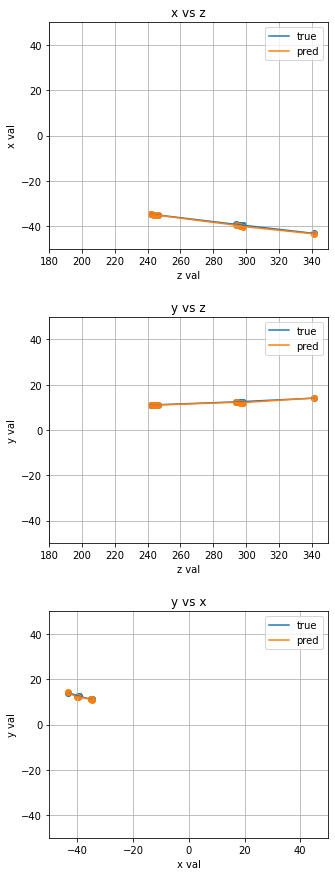

KeyboardInterrupt: ignored

In [ ]:
from time import sleep
from IPython.display import clear_output
height = 3
width = 1
index = 1



for index in range(15):
  clear_output(wait=True)
  print("index:", index)
  fig, ax = plt.subplots(height,width,figsize=(width*5,height*5))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  ax[0].scatter(z_az[index,:,0],true[index,:,0])
  ax[0].scatter(z_az[index,:,0],pred[index,:,0])
  ax[0].plot(z_az[index,:,0],true[index,:,0])
  ax[0].plot(z_az[index,:,0],pred[index,:,0])
  ax[0].set_xlim([180,350])
  ax[0].set_ylim([-50,50])
  ax[0].set_xlabel("z val")
  ax[0].set_ylabel("x val")
  ax[0].set_title("x vs z")
  ax[0].legend(["true","pred"])
  ax[0].grid(True)
  # ax[0].set_ylim([0,50])

  ax[1].scatter(z_az[index,:,0],true[index,:,1])
  ax[1].scatter(z_az[index,:,0],pred[index,:,1])
  ax[1].plot(z_az[index,:,0],true[index,:,1])
  ax[1].plot(z_az[index,:,0],pred[index,:,1])
  ax[1].set_xlim([180,350])
  ax[1].set_ylim([-50,50])
  ax[1].set_xlabel("z val")
  ax[1].set_ylabel("y val")
  ax[1].set_title("y vs z")
  ax[1].legend(["true","pred"])
  ax[1].grid(True)
  # ax[1].set_ylim([0,50])

  ax[2].scatter(true[index,:,0],true[index,:,1])
  ax[2].scatter(pred[index,:,0],pred[index,:,1])
  ax[2].plot(true[index,:,0],true[index,:,1])
  ax[2].plot(pred[index,:,0],pred[index,:,1])
  ax[2].set_xlim([-50,50])
  ax[2].set_ylim([-50,50])
  ax[2].set_xlabel("x val")
  ax[2].set_ylabel("y val")
  ax[2].set_title("y vs x")
  ax[2].legend(["true","pred"])
  ax[2].grid(True)
  fig.show()
  # sleep(5)
  plt.pause(3.5)


## Graphs

### Graph loss and mae

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
loss:  [24.77764320373535, 3.8807315826416016, 2.0113844871520996, 1.5805679559707642, 1.4872894287109375, 1.4083430767059326, 1.3471578359603882, 1.297995924949646, 1.2661874294281006, 1.2501832246780396, 1.2353696823120117, 1.386547327041626, 1.1915465593338013, 1.2065565586090088, 1.212778925895691, 1.345276951789856, 1.184442162513733, 1.1838220357894897, 1.1375083923339844, 1.1066007614135742, 1.0857040882110596, 1.067989706993103, 1.0632158517837524, 1.0548434257507324, 1.0472187995910645, 1.0409685373306274, 1.0337947607040405, 1.0252859592437744, 1.0106267929077148, 0.9965402483940125, 0.9699358344078064, 0.9332659840583801, 0.8762682676315308, 0.7884187698364258, 0.7063685059547424, 0.6218578815460205, 0.5529812574386597, 0.5091169476509094, 0.4471454918384552, 0.439384788274765, 0.41958391666412354, 0.39367666840553284, 0.3970852792263031, 0.3842678368091583, 0.38316234946250916, 0.3740616738796234, 0.37235817313194275, 0.3736

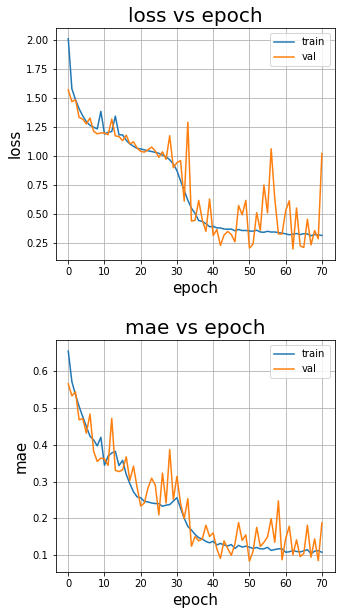

In [ ]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
print("val_loss: ", H.history["val_loss"])
print("val_mae: ", H.history["val_mae"])

lim = 2

try:
  print(H.history["x_out_loss"])
  fig, ax = plt.subplots(1,2,figsize=(10,5))

  # ax[0].plot(H.history["loss"])
  ax[0].plot(H.history["x_out_loss"][lim:])
  ax[0].plot(H.history["y_out_loss"][lim:])
  ax[0].plot(H.history["z_out_loss"][lim:])
  ax[0].plot(H.history["px_out_loss"][lim:])
  ax[0].plot(H.history["py_out_loss"][lim:])
  ax[0].plot(H.history["pz_out_loss"][lim:])
  ax[0].set_title("epoch vs loss")

  ax[1].plot(H.history["x_out_mae"][lim:])
  ax[1].plot(H.history["y_out_mae"][lim:])
  ax[1].plot(H.history["z_out_mae"][lim:])
  ax[1].plot(H.history["px_out_mae"][lim:])
  ax[1].plot(H.history["py_out_mae"][lim:])
  ax[1].plot(H.history["pz_out_mae"][lim:])
  ax[1].set_title("epoch vs mae")
  
except KeyError:
    fig, ax = plt.subplots(2,1,figsize=(5,10))
    fig.subplots_adjust(hspace=0.35)

    ax[0].plot(H.history["loss"][lim:])
    ax[0].plot(H.history["val_loss"][lim:])
    ax[0].set_title("loss vs epoch", fontsize=20)
    ax[0].set_xlabel("epoch", fontsize=15)
    ax[0].set_ylabel("loss", fontsize=15)
    ax[0].legend(["train","val"])
    ax[0].grid(True)


    ax[1].plot(H.history["mae"][lim:])
    ax[1].plot(H.history["val_mae"][lim:])
    ax[1].set_title("mae vs epoch", fontsize=20)
    ax[1].set_xlabel("epoch", fontsize=15)
    ax[1].set_ylabel("mae", fontsize=15)
    ax[1].legend(["train","val"])
    ax[1].grid(True)


### Graph


In [ ]:
def doPlots(true_y,pred,diff):

  howMany = 5

  fig, axs = plt.subplots(4,howMany,figsize=(30,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  # values = ['x','y','z','px','py','pz']
  # limits = [[-40,40],[-40,40],[150,350],[-0.2,0.2],[-0.2,0.2],[0.5,3.5]]
  values = ['x','y','px','py','pz']
  limits = [[-40,40],[-40,40],[-0.2,0.2],[-0.2,0.2],[0.5,3.5]]

  for i in range(howMany):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , values[i] ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

    axs[0,i].set_title(values[i] + ' diff')
    axs[0,i].set_ylabel('freq')
    axs[0,i].set_xlabel(values[i] + ' diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(howMany):
    axs[1,i].scatter(true_y[:,i],pred[:,i])
    axs[1,i].grid(True)

    axs[1,i].set_title(values[i] + ' (predicted vs true)')
    axs[1,i].set_ylabel('pred ' + values[i])
    axs[1,i].set_xlabel('true ' + values[i])

    axs[1,i].set_xlim(limits[i])
    axs[1,i].set_ylim(limits[i])
    axs[1,i].plot(limits[i],limits[i], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(howMany):
    axs[2,i].scatter(true_y[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(howMany):
    axs[3,i].hist2d(true_y[:,i],diff[:,i],bins=20)

    axs[2,i].set_title(values[i] + ' (difference vs true)')
    axs[2,i].set_ylabel('diff ' + values[i])
    axs[2,i].set_xlabel('true ' + values[i])

  fig.show()

### Actual Graphs

true:  (1000, 5)
pred:  (1000, 5)
diff:  (1000, 5)
data x  |: mu:  0.014348326612540813 sigma:  0.06706171831432498
data y  |: mu:  0.006164382100665287 sigma:  0.052924019222192004
data px  |: mu:  0.000947109462960492 sigma:  0.01924053509948995
data py  |: mu:  -0.006013369634667114 sigma:  0.02088260435265241
data pz  |: mu:  0.09126054513292695 sigma:  0.03277278209246113


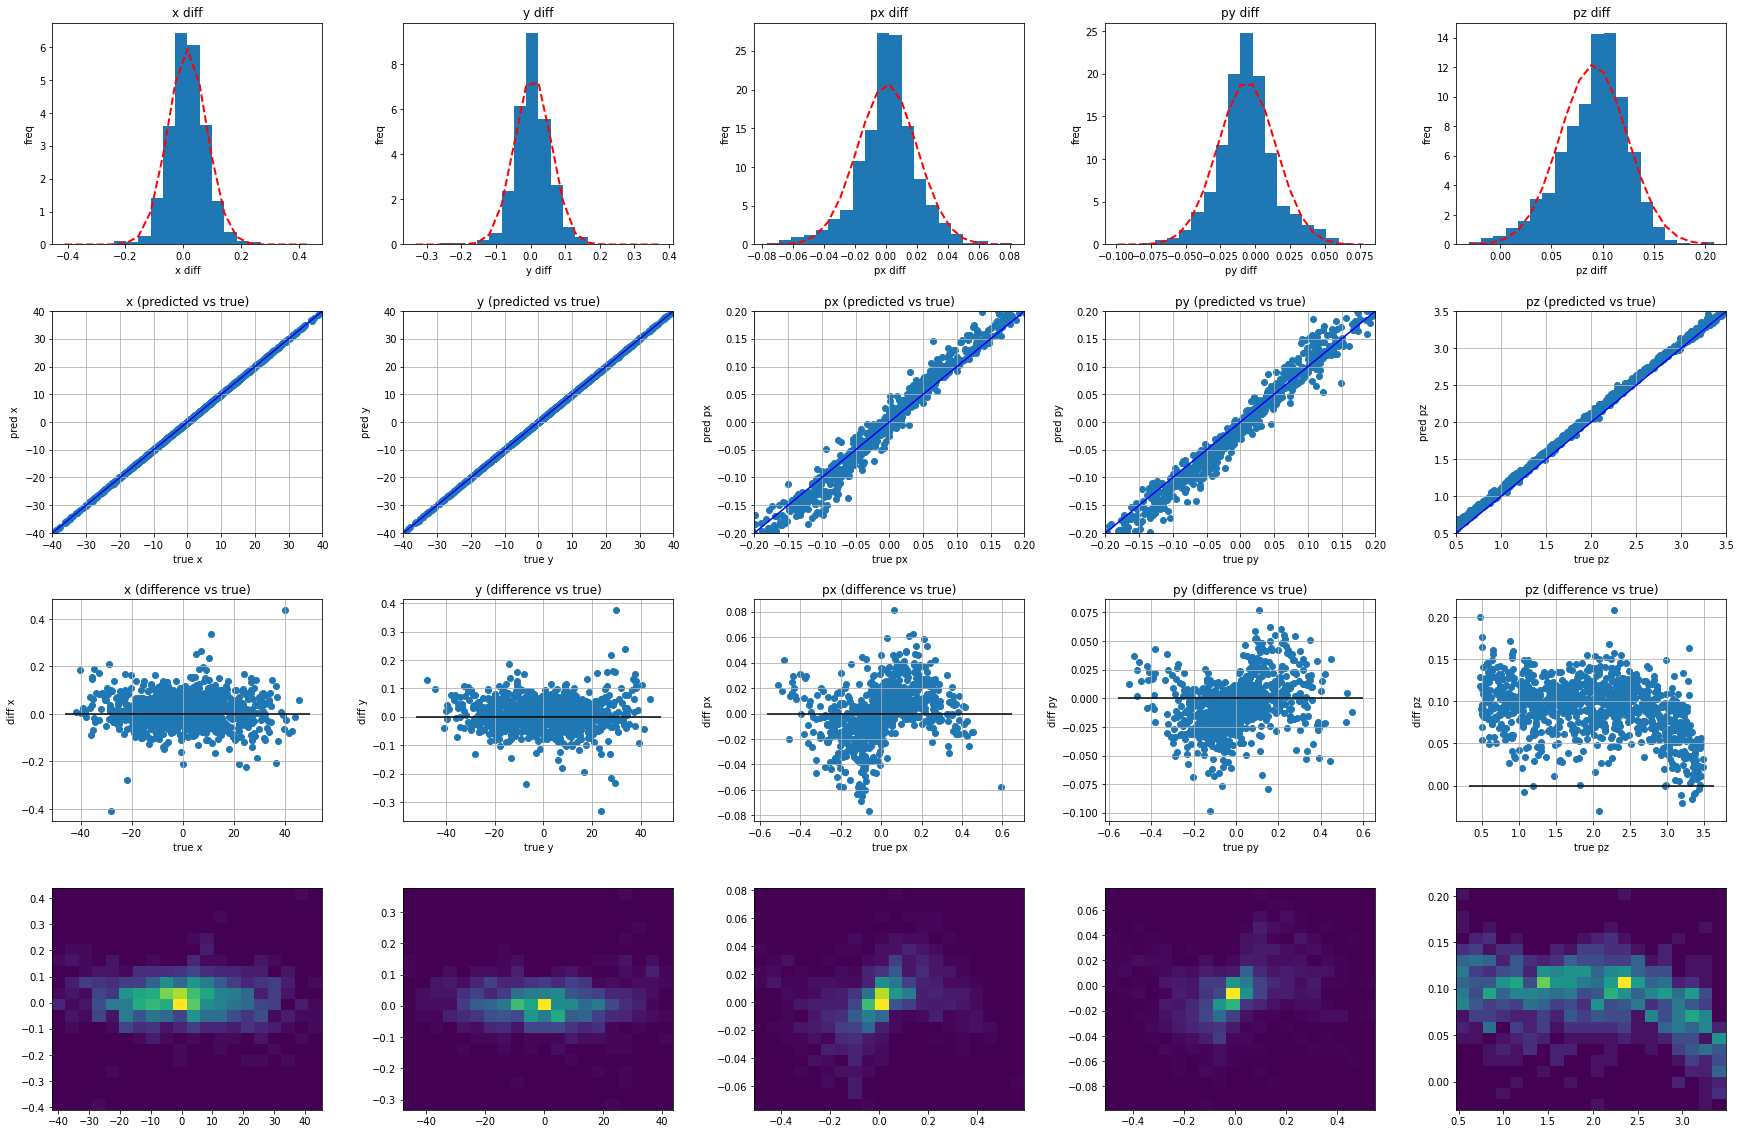

In [ ]:
def generate_time_distributed_data(x_test, y_test, number=1000, index=23):
  skip = 0
  test_x = x_train[skip:number+skip]
  true_y = y_train[skip:number+skip]

  pred = model.predict(test_x)

  true_y = true_y[:,index]
  pred = pred[:,index]
  diff = pred - true_y

  # for d in range(len(diff)):
  #   if diff[d][0] > 1:
  #     print(d,diff[d])


  print("true: ",true_y.shape)
  print("pred: ",pred.shape)
  print("diff: ",diff.shape)
  return true_y, pred, diff

def generate_time_stateful_data(x_test, y_test, number=1000, index=23):
  test_x = x_train[:number]
  true_y = y_train[:number]

  _pred = []
  for s_batch in test_x:
    s_batch = np.expand_dims(s_batch,axis=0)
    _pred.append(model.predict(s_batch,batch_size=1))
    model.reset_states();
  _pred = np.squeeze(np.array(pred_))

  true_y = true_y[:,index]
  pred = _pred[:,index]
  diff = pred - true_y
  print("true: ",true_y.shape)
  print("pred: ",pred.shape)
  print("diff: ",diff.shape)
  return true_y, pred, diff

def generate_graph_data(x_test, y_test, number=1000):
  test_x = x_train[:number]
  true_y = y_train[:number]

  pred = model.predict(test_x)
  diff = pred - true_y
  print("true: ",true_y.shape)
  print("pred: ",pred.shape)
  print("diff: ",diff.shape)
  return true_y, pred, diff

true_y, pred, diff = generate_time_distributed_data(x_newtest, y_newtest, index=7)

doPlots(true_y,pred,diff)

In [ ]:
index = 0
doPlots(true_y[:,index], pred[:,index], diff[:,index])

In [ ]:
index = val_y.shape[1]-1
doPlots(np.array(true_y_[:,index,:]),np.array(pred_[:,index,:]),np.array(diff_[:,index,:]))

In [ ]:
index = 1
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

In [ ]:
index = 2
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

In [ ]:
index = 3
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

## Depricated

Most likey not needed, but safe keeping

In [ ]:
# reset states of the model
# https://stackoverflow.com/questions/43882796/when-does-keras-reset-an-lstm-state
# model.reset_states()

# model.layers[0].batch_size = 1
# model.layers[0].batch_shape = 1
# model.layers[1].stateful = True
# model.layers[2].stateful = True
# model.layers[3].stateful = True

# model.layers[1].stateful = False
# model.layers[2].stateful = False
# model.layers[3].stateful = False

In [ ]:
def RNN(inp,x):
  x = keras.layers.LSTM(10,activation="relu", input_shape=inp, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(6,activation="linear"))(x)
  return x
def RNNOther(inp,x):
  # CuDNN
  x = keras.layers.GRU(256, return_sequences=True)(x)
  x = keras.layers.SimpleRNN(64, activation="linear")(x)
  x = keras.layers.Dense(6,activation="linear")(x)
  return x

def DenseTest(x):
  x = keras.layers.Dense(128, activation='tanh')(x)
  x = keras.layers.Dense(64, activation='tanh')(x)
  x = keras.layers.Dense(32, activation='tanh')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dense(6, activation='linear')(x)
  return x

In [ ]:
# Goes under ## Build model tag

# --==Categorize each output seperately==-- begin
# x = RNNExtra((None,6),inputs)
# out = split_it(x)
# outputs = {
#     "x_out":out[0],
#     "y_out":out[1],
#     "z_out":out[2],
#     "px_out":out[3],
#     "py_out":out[4],
#     "pz_out":out[5]
# }
# model = keras.Model(inputs=inputs, outputs=outputs, name="RNNModelJLab")
# --==Categorize each output seperately==-- end

In [ ]:

def data_generator(x_data,y_data):
  size = len(x_data)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  while True:
    s = np.arange(size)
    np.random.shuffle(s)
    counter = 0
    x_arr = []
    y_arr = []
    for x, y in zip(x_data[s],y_data[s]):
    # for x, y in zip(x_data,y_data):s
    
      x = np.expand_dims(x,0)
      # y = np.expand_dims(y,0)
      
      # x = tf.ragged.constant(x)
      # y = tf.ragged.constant(y)

      x_arr.append(x)
      y_arr.append(y)
      counter += 1

      if counter == 1:
        counter = 0
        yield x_arr,y_arr
        x_arr = []
        y_arr = []
      
train_gen = data_generator(x_train,y_train)
val_gen = data_generator(val_x,val_y)
x ,y = next(val_gen)
print(len(x), x[0].shape)
print(len(y), y[0].shape)

In [ ]:
# def parser(data, thisBool):
#   data = data[0:10]
#   # print(data.shape)
#   step = 6
#   inputs = 6
#   outputs = 6
#   z_loc = 2

#   batch_x = []
#   batch_y = []

#   for i in range(len(data)):
#     index = 0 
#     full_set_x = []
#     full_set_y = []
#     while index+inputs+outputs < len(data[i]):
#       mid = index + inputs
#       one_set_x = np.append(data[i][index:mid],data[i][mid+z_loc])
#       one_set_y = data[i][mid:mid+outputs]
#       flag = False
#       for x in one_set_x:
#         if isnan(x):
#           flag = True
#       for y in one_set_y:
#         if isnan(y):
#           flag = True
#       if flag:
#         break
#       full_set_x.append(one_set_x)
#       full_set_y.append(one_set_y)
#       index += step
#     batch_x.append(full_set_x)
#     batch_y.append(full_set_y)

#   if thisBool:
#     batch_x = np.array(batch_x)
#     batch_y = np.array(batch_y)
#     print("x",batch_x.shape)
#     print("y",batch_y.shape)
#   return batch_x,batch_y

# x_train,y_train = parser(train_x, True)
# # print("train0:",x_train[0].shape)
# print("val")
# val_x, val_y = parser(val_data, False)
# for set_ in range(len(val_x)):
#   val_x[set_] = np.array(val_x[set_])
# for set_ in range(len(val_y)):
#   val_y[set_] = np.array(val_y[set_])

# # val_x = np.array(val_x)



In [ ]:

diff_x = []
true_x = []
if False:
  pred = []
  for i in range(20):
    v = np.expand_dims(val_x[i],0)
    p = model.predict( v )
    p = np.squeeze(p)
    pred.append(p)

  for x in range(20):
    # for rr in range(len(val_x[x])):
    for rr in range(np.ma.size(val_x[x],1)):
      diff_x.append(val_x[x][rr] - pred[x][0,rr])
      true_x.append(val_x[x][rr])
else:
  pred = model.predict(x_train[:20])

  for x in range(20):
    for rr in range(len(y_train[x])):
      diff_x.append(y_train[x][rr] - pred[x][rr])
      true_x.append(y_train[x][rr])
  # for x in range(20):
  #   for rr in range(len(x_train[x])):
  #     diff_x.append(x_train[x][rr] - pred[x][rr])
  #     true_x.append(x_train[x][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20,range=[-20,20])
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')


  


axs[1,0].scatter(true_x[:,0],pred[:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[:,:,1])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[:,:,2])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[:,:,3])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[:,:,4])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[:,:,5])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)


axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



In [ ]:

useStrings = False
numOfSets = 10

batch_size = 1

diff_x = []
true_x = []
betterYArr = []
betterPred = []




smallData = False
if smallData:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(train_gen)
    for aa in range(1):
      p = model.predict( v[aa] )
      p = np.squeeze(p)
      y_a = np.squeeze(y[aa])
      yArr.append(y_a)
      pred.append(p)

  for set_ in range(numOfSets*1):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(pred[set_][rr] - yArr[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])

else:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(val_gen)
    for aa in range(batch_size):
      p = model.predict( v[aa] )
      p = np.squeeze(p)
      y_a = np.squeeze(y[aa])
      yArr.append(y_a)
      pred.append(p)

  for set_ in range(numOfSets*batch_size):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(pred[set_][rr] - yArr[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
betterYArr = np.array(betterYArr)
betterPred = np.array(betterPred)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

#--------------------------------------
# DIFF 1D HIST
#--------------------------------------



for i in range(6):
  (mu, sigma) = norm.fit(diff_x[:,i])
  print("data" , i ," |: mu: ", mu, "sigma: " , sigma)
  _, bins, _ = axs[0,i].hist(diff_x[:,i], 20, density=True)
  y = norm.pdf(bins, mu, sigma)
  l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

# axs[0,0].set_xlim([-10,10])

axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')

#--------------------------------------
# PREDICTED VS TRUE
#--------------------------------------
  
for i in range(6):
  axs[1,i].scatter(true_x[:,i],betterPred[:,i])
  axs[1,i].grid(True)

  # xl, xr = axs[1,i].get_xlim()
  # yl, yr = axs[1,i].get_ylim()
  # mmin = min(xr,yr)
  # mmax = max(xl,yl)
  # axs[1,i].plot([mmax,mmin],[mmax,mmin], color='b')

axs[1,0].set_title('X (predicted vs true)')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].set_xlim([-40,40])
axs[1,0].set_ylim([-40,40])
axs[1,0].plot([-40,40],[-40,40], color='b')

axs[1,1].set_title('Y (predicted vs true)')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].set_xlim([-40,40])
axs[1,1].set_ylim([-40,40])
axs[1,1].plot([-40,40],[-40,40], color='b')

axs[1,2].set_title('Z (predicted vs true)')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].set_xlim([150,350])
axs[1,2].set_ylim([150,350])
axs[1,2].plot([150,350],[150,350], color='b')

axs[1,3].set_title('PX (predicted vs true)')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].set_xlim([-0.2,0.2])
axs[1,3].set_ylim([-0.2,0.2])
axs[1,3].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,4].set_title('PY (predicted vs true)')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].set_xlim([-0.2,0.2])
axs[1,4].set_ylim([-0.2,0.2])
axs[1,4].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,5].set_title('PZ (predicted vs true)')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].set_xlim([0.5,3.5])
axs[1,5].set_ylim([0.5,3.5])
axs[1,5].plot([0.5,3.5],[0.5,3.5], color='b')

#--------------------------------------
# DIFFERENCE VS TRUE
#--------------------------------------

for i in range(6):
  axs[2,i].scatter(true_x[:,i],diff_x[:,i])
  l, r = axs[2,i].get_xlim()
  axs[2,i].hlines(0, l, r)
  axs[2,i].grid(True)

axs[2,0].set_title('X (difference vs true)')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')

axs[2,1].set_title('Y (difference vs true)')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')

axs[2,2].set_title('Z (difference vs true)')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')

axs[2,3].set_title('PX (difference vs true)')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')

axs[2,4].set_title('PY (difference vs true)')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')

axs[2,5].set_title('PZ (difference vs true)')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')

#--------------------------------------
# DIFFERENCE VS TRUE 2D HIST
#--------------------------------------

for i in range(6):
  axs[3,i].hist2d(true_x[:,i],diff_x[:,i],bins=20)


axs[3,0].set_title('X (difference vs true)')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].set_title('Y (difference vs true)')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].set_title('Z (difference vs true)')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].set_title('PX (difference vs true)')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].set_title('PY (difference vs true)')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].set_title('PZ (difference vs true)')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



In [ ]:

diff_x = []
true_x = []

if False:
  pred_ = model.predict(val_x[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(val_x[x])):
      diff_x.append(val_x[x][rr] - pred[:,x,rr,0])
      true_x.append(val_x[x][rr])
else:
  pred_ = model.predict(x_train[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(x_train[x])):
      diff_x.append(x_train[x][rr] - pred[:,x,rr,0])
      true_x.append(x_train[x][rr])


diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20)
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')




axs[1,0].scatter(true_x[:,0],pred[0,:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[1,:,:,0])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[2,:,:,0])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[3,:,:,0])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[4,:,:,0])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[5,:,:,0])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)



axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')

In [ ]:
# def parser(data, randomInput):
#   data = data[:20]
#   print(len(data))
#   print(len(data[0]))
#   print(train_x[:20])
#   step = 6
#   inputs = 6
#   outputs = 6
#   inputLayers = 8

#   batches_x = []
#   batches_y = []

#   for i in range(len(data)):
#     index = 0 
#     one_set_x = []
#     one_set_y = []
#     # full_set_x = []
#     # full_set_y = []
#     while index+inputs+outputs < len(data[i]):
#       if randomInput:
#         inputLayers = np.random.choice([3,4,5,6,7,8,9])
#       mid = index + inputs
#       one_set_x.append(data[i][index:mid]) # + data[i,mid+3] # later fix to get z value
#       # one_set_y = data[i][mid:mid+outputs]
#       # one_set_y.append(data[i][mid:mid+outputs])
#       flag = False
#       for x in one_set_x[-1]:
#         if isnan(x):
#           flag = True
#       if flag:
#         break
#       if randomInput:
#         if len(one_set_x) >= inputLayers:
#           one_set_x = one_set_x[:inputLayers]
#           one_set_y = data[i][mid-(len(one_set_x)-inputLayers):mid+outputs-(len(one_set_x)-inputLayers)]
#           for y in one_set_y:
#             if isnan(y):
#               flag = True
#           if flag:
#             break
#           # full_set_x.append(one_set_x)
#           # full_set_y.append(one_set_y)
#           send = np.expand_dims(one_set_x,0)
#           sendy = np.expand_dims(one_set_y,0)
#           # send = np.array(one_set_x)
#           batches_x.append(send)
#           batches_y.append(sendy)
#           one_set_x = one_set_x[1:]
#           # one_set_y = one_set_y[1:]
#       else:
#         if len(one_set_x) == inputLayers:
#           one_set_y = data[i][mid:mid+outputs]
#           for y in one_set_y:
#             if isnan(y):
#               flag = True
#           if flag:
#             break
#           send = np.expand_dims(one_set_x,0)
#           sendy = np.expand_dims(one_set_y,0)
#           # send = np.array(one_set_x)
#           batches_x.append(send)
#           batches_y.append(sendy)
#           one_set_x = one_set_x[1:]
#       index += step

#     # batch_x.append(full_set_x)
#     # batch_y.append(full_set_y)

#   # batches_x = np.array(batches_x)
#   # batches_y = np.array(batches_y)
#   # batches_y = np.expand_dims(batches_y,1)
#   print("bachx: ",batches_x)
#   print("bachy: ",batches_y)
#   print("0x",len(batches_x))
#   print("1x",len(batches_x[0]))
#   print("2x",len(batches_x[0][0]))
#   print("3x",len(batches_x[0][0][0]))
#   print("0y",len(batches_y))
#   print("1y",len(batches_y[0]))
#   print("2y",len(batches_y[0][0]))
#   print("x", len(batches_x), batches_x[0].shape)
#   # print("y",batches_y.shape)
#   return batches_x,batches_y

# x_train,y_train = parser(train_x, False)
# print("val")
# val_x, val_y = parser(val_data, True)
# # print("train0:",x_train[0].shape)
# # print("val")
# # val_x, val_y = parser(val_data, False)
# # for set_ in range(len(val_x)):
# #   val_x[set_] = np.array(val_x[set_])
# # for set_ in range(len(val_y)):
# #   val_y[set_] = np.array(val_y[set_])

# # val_x = np.array(val_x)


# # normalization
# # takes the max and min values inside the array
# max = 0
# min = 0
# for i in x_train:
#   mx = i.max()
#   mn = i.min()
#   if mx > max:
#     max = mx
#   if mn < min:
#     min = mn
# #      translates to be 0 to (max-min), then normalize by divinding
# x_train = (x_train - min) / (max - min)
# for i in range(len(val_x)):
#   val_x[i] = (val_x[i] - min) / (max - min)


# print("train x: ",len(x_train),x_train[0].shape)
# print("train y: ",len(y_train), y_train[0].shape)
# print("val x: ",len(val_x),val_x[0].shape)
# print("val y: ",len(val_y),val_y[0].shape)



In [ ]:
# # =============
# # --==Graph==--
# # =============
# def graph_missing_test(diff, pred, true, index_start, index_end, graph_index=0):
#   height = (index_end - (index_start-1)) + 1
#   width = 2
#   # experimental code start
#   if index_start == 1:
#     height = 1
#   # experimental code end

#   values = ['x','y','z','px','py','pz']
#   limits = [[-40,40],[-40,40],[60,350],[-0.2,0.2],[-0.2,0.2],[0.5,3.5]]

#   fig, ax = plt.subplots(height,width,figsize=(width*5,height*5))
#   fig.subplots_adjust(wspace=0.3, hspace=0.3)

#   # experimental code start
#   # if index_start == 1:

#   #   (mu, sigma) = norm.fit(diff[:,0,graph_index])
#   #   print("data" , str(x_newtest.shape[1]-1) ," |: mu: ", mu, "sigma: " , sigma)
#   #   _, bins, _ = ax[0].hist(diff[:,0,graph_index], 20, density=True)
#   #   y = norm.pdf(bins, mu, sigma)
#   #   l = ax[0].plot(bins, y, 'r--', linewidth=2)

#   #   ax[0].set_title("index: " + str(x_newtest.shape[1]-1))
#   #   ax[0].set_ylabel('ylabel')
#   #   ax[0].set_xlabel('xlabel')

#   #   ax[1].scatter(true[:,0,graph_index],pred[:,0,graph_index])
#   #   ax[1].grid(True)

#   #   ax[1].set_title("index: " + str(x_newtest.shape[1]-1) + " pred vs true")
#   #   ax[1].set_ylabel("ylabel")
#   #   ax[1].set_xlabel("xlabel")

#   #   ax[1].set_xlim(limits[graph_index])
#   #   ax[1].set_ylim(limits[graph_index])
#   #   ax[1].plot(limits[graph_index],limits[graph_index], color='b')
#   #   fig.show()
#   #   return
#   # experimental code end


#   # if width > 1:
#   for row in range(height-1):

#     (mu, sigma) = norm.fit(diff[:,row,graph_index])
#     print("data" , str(row+index_start) ," |: mu: ", mu, "sigma: " , sigma)
#     _, bins, _ = ax[row,0].hist(diff[:,row,graph_index], 20, density=True)
#     y = norm.pdf(bins, mu, sigma)
#     l = ax[row,0].plot(bins, y, 'r--', linewidth=2)

#     ax[row,0].set_title("index: " + str(row+index_start))
#     ax[row,0].set_ylabel('ylabel')
#     ax[row,0].set_xlabel('xlabel')


#     ax[row,1].scatter(true[:,row,graph_index],pred[:,row,graph_index])
#     ax[row,1].grid(True)

#     ax[row,1].set_title("index: " + str(row+index_start) + " pred vs true")
#     ax[row,1].set_ylabel("ylabel")
#     ax[row,1].set_xlabel("xlabel")

#     ax[row,1].set_xlim(limits[graph_index])
#     ax[row,1].set_ylim(limits[graph_index])
#     ax[row,1].plot(limits[graph_index],limits[graph_index], color='b')


#   (mu, sigma) = norm.fit(diff[:,height-1,graph_index])
#   print("data" , str(x_newtest.shape[1]-1) ," |: mu: ", mu, "sigma: " , sigma)
#   _, bins, _ = ax[height-1,0].hist(diff[:,height-1,graph_index], 20, density=True)
#   y = norm.pdf(bins, mu, sigma)
#   l = ax[height-1,0].plot(bins, y, 'r--', linewidth=2)

#   ax[height-1,0].set_title("index: " + str(x_newtest.shape[1]-1))
#   ax[height-1,0].set_ylabel('ylabel')
#   ax[height-1,0].set_xlabel('xlabel')

#   ax[height-1,1].scatter(true[:,height-1,graph_index],pred[:,height-1,graph_index])
#   ax[height-1,1].grid(True)

#   ax[height-1,1].set_title("index: " + str(x_newtest.shape[1]-1) + " pred vs true")
#   ax[height-1,1].set_ylabel("ylabel")
#   ax[height-1,1].set_xlabel("xlabel")

#   ax[height-1,1].set_xlim(limits[graph_index])
#   ax[height-1,1].set_ylim(limits[graph_index])
#   ax[height-1,1].plot(limits[graph_index],limits[graph_index], color='b')


    
#   # else:
#   #   for row in range(height-1):
#   #     (mu, sigma) = norm.fit(diff[:,row,graph_index])
#   #     print("data" , str(row+index_start) ," |: mu: ", mu, "sigma: " , sigma)
#   #     _, bins, _ = ax[row].hist(diff[:,row,graph_index], 20, density=True)
#   #     y = norm.pdf(bins, mu, sigma)
#   #     l = ax[row].plot(bins, y, 'r--', linewidth=2)

#   #     # ax[row].scatter(true_y[:,i],pred[:,i])
#   #     # ax[row].grid(True)

#   #     ax[row].set_title("index: " + str(row+index_start))
#   #     ax[row].set_ylabel('ylabel')
#   #     ax[row].set_xlabel('xlabel')

#   #   (mu, sigma) = norm.fit(diff[:,height-1,graph_index])
#   #   print("data" , str(x_newtest.shape[1]-1) ," |: mu: ", mu, "sigma: " , sigma)
#   #   _, bins, _ = ax[height-1].hist(diff[:,height-1,graph_index], 20, density=True)
#   #   y = norm.pdf(bins, mu, sigma)
#   #   l = ax[height-1].plot(bins, y, 'r--', linewidth=2)

#   #   # ax[row,0].scatter(true_y[:,i],pred[:,i])
#   #   # ax[row,0].grid(True)

#   #   ax[height-1].set_title("index: " + str(x_newtest.shape[1]-1))
#   #   ax[height-1].set_ylabel('ylabel')
#   #   ax[height-1].set_xlabel('xlabel')


#   fig.show()
